In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, nbinom
from scipy.special import logsumexp
from statsmodels.tsa.stattools import acf
import math
from numba import njit
import time 
from math import lgamma
from tqdm import trange
import os



import importlib
import utils.cox_simulation as cox
import utils.plots as pl
import utils.exact_filter as ef
import utils.particle_v1 as p1
import utils.particle_v2 as p2

importlib.reload(cox)
importlib.reload(pl)
importlib.reload(ef)
importlib.reload(p1)
importlib.reload(p2)

<module 'utils.particle_v2' from '/home/onyxia/work/Non-Gaussian-State-Space-Models/utils/particle_v2.py'>

## Simulation of data

In [15]:
TRUE_PARAMS = {"phi": 0.9, "nu": 2.5, "c": 0.2}
T_sim = 3000

sim = cox.CoxProcessSimulation(T=T_sim, **TRUE_PARAMS, seed=123)

y, h, z, lam = sim.simulate(init="burnin",burn_in=500, h0=1.0, return_lambda=True)

print("Simulation finished.")
print(f"Mean(y) = {y.mean():.3f}")
print(f"Mean(h) = {h.mean():.3f}")
print(f"Max(z)  = {z.max()}")

Simulation finished.
Mean(y) = 5.049
Mean(h) = 4.985
Max(z)  = 97


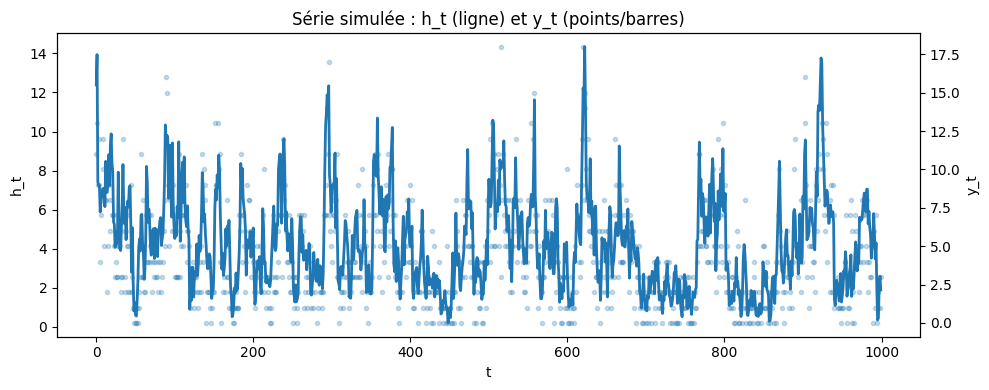

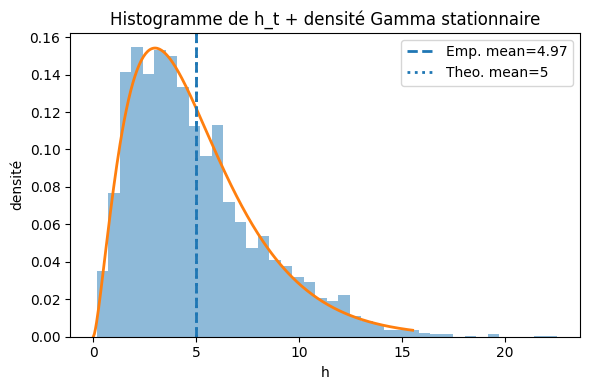

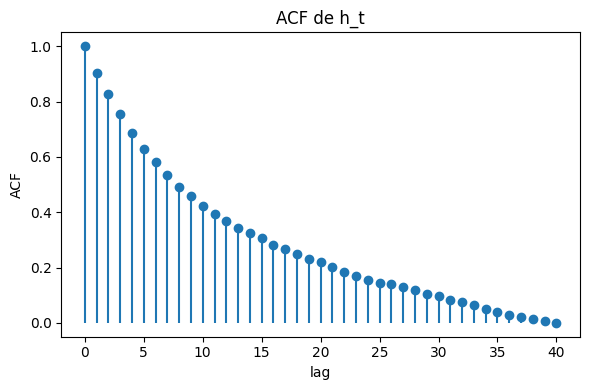

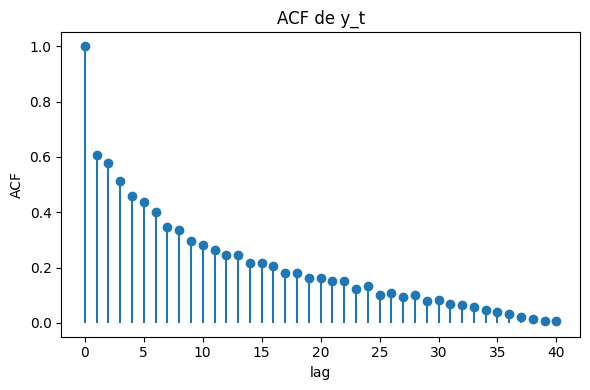

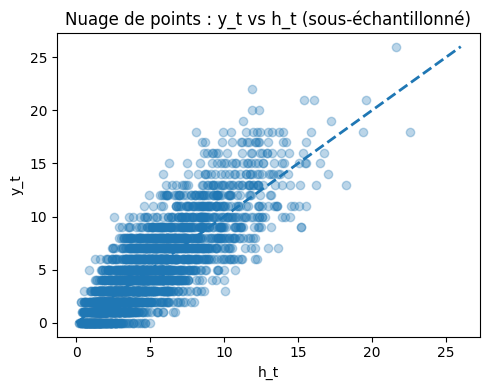

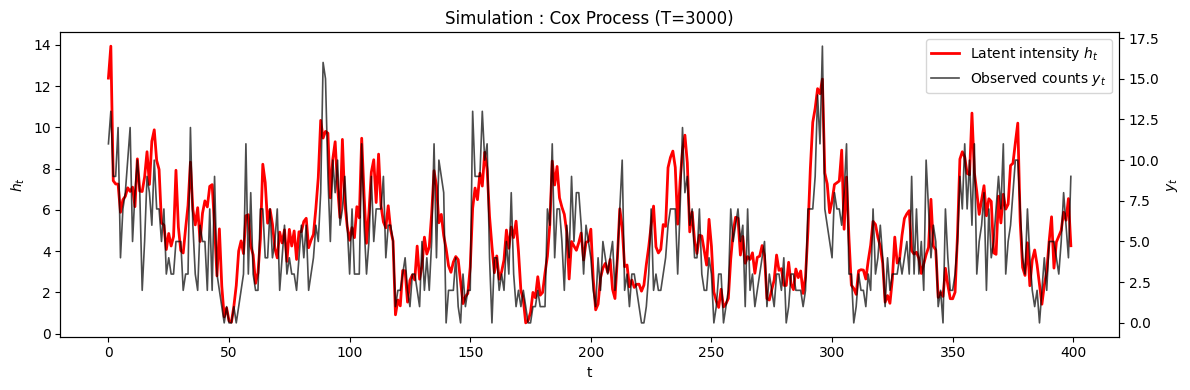

In [16]:
pl.plot_time_series(y, h, T_show=1000, start=0, use_bars=False)
pl.plot_histogram_h(h, nu=TRUE_PARAMS["nu"], phi=TRUE_PARAMS["phi"], c=TRUE_PARAMS["c"], burn=200)
pl.plot_acf_h(h, lags=40, burn=200)
pl.plot_acf_y(y, lags=40, burn=200)
pl.plot_scatter_y_h(y, h, max_points=3000)
pl.plot_overlay_clean(y, h, T_show=400, start=0)

## Seeing the impact of the choice of Z

In [18]:
Z_list = [20, 30, 40, 50, 75, 100, 200, 400, 800]


loglikes = []
times = []
max_pZ_list = []

# permet de compiler avec Numba une première fois (comme échauffement pour pas prendre en compte ce temps dans les résultats)
_ = ef.ExactFilter(y, Z_trunc=Z_list[0]).log_likelihood(
    **TRUE_PARAMS
)

# Z-truncation study

for Z in Z_list:
    f = ef.ExactFilter(y, Z_trunc=Z)

    t0 = time.time()
    ll, max_pZ = f.log_likelihood(
        return_diag=True,
        **TRUE_PARAMS
    )
    t1 = time.time()

    loglikes.append(ll)
    times.append(t1 - t0)
    max_pZ_list.append(max_pZ)

    print(
        f"Z={Z:4d} | log-like={ll:12.2f} | "
        f"time={t1-t0:6.2f}s | max P(z=Z|y)={max_pZ:.2e}"
    )


Z=  20 | log-like=    -9910.75 | time=  0.09s | max P(z=Z|y)=5.79e-01
Z=  30 | log-like=    -8186.72 | time=  0.20s | max P(z=Z|y)=4.26e-01
Z=  40 | log-like=    -7487.87 | time=  0.31s | max P(z=Z|y)=3.11e-01
Z=  50 | log-like=    -7200.38 | time=  0.49s | max P(z=Z|y)=2.21e-01
Z=  75 | log-like=    -7031.51 | time=  1.03s | max P(z=Z|y)=7.31e-02
Z= 100 | log-like=    -7021.58 | time=  1.95s | max P(z=Z|y)=1.01e-02
Z= 200 | log-like=    -7021.35 | time=  7.30s | max P(z=Z|y)=6.27e-14
Z= 400 | log-like=    -7021.35 | time= 30.09s | max P(z=Z|y)=1.91e-35
Z= 800 | log-like=    -7021.35 | time=117.11s | max P(z=Z|y)=1.05e-81


In [19]:
# Référence
ll_ref = loglikes[-1]

# DataFrame
results = pd.DataFrame({
    "Z": Z_list,
    "log_likelihood": loglikes,
    "Diff_logL_vs_Zmax": [ll - ll_ref for ll in loglikes],
    "time_sec": times,
    "max_P_z_eq_Z": max_pZ_list
})

# Enregistrement en CSV
results.to_csv("results_Z_truncation.csv", index=False)
results

,Z,log_likelihood,Diff_logL_vs_Zmax,time_sec,max_P_z_eq_Z
0,20,-9910.746198,-2.889397e+03,0.088467,5.794250e-01
1,30,-8186.717311,-1.165368e+03,0.196151,4.258677e-01
2,40,-7487.874328,-4.665248e+02,0.306626,3.105382e-01
3,50,-7200.381857,-1.790323e+02,0.488400,2.207321e-01
4,75,-7031.507038,-1.015748e+01,1.026412,7.310483e-02
5,100,-7021.579747,-2.301873e-01,1.951406,1.005345e-02
6,200,-7021.349560,1.818989e-12,7.296757,6.274520e-14
7,400,-7021.349560,0.000000e+00,30.093023,1.905215e-35
8,800,-7021.349560,0.000000e+00,117.108392,1.052568e-81


In [20]:
results = pd.read_csv("results_Z_truncation.csv")
results

,Z,log_likelihood,Diff_logL_vs_Zmax,time_sec,max_P_z_eq_Z
0,20,-9910.746198,-2.889397e+03,0.088467,5.794250e-01
1,30,-8186.717311,-1.165368e+03,0.196151,4.258677e-01
2,40,-7487.874328,-4.665248e+02,0.306626,3.105382e-01
3,50,-7200.381857,-1.790323e+02,0.488400,2.207321e-01
4,75,-7031.507038,-1.015748e+01,1.026412,7.310483e-02
5,100,-7021.579747,-2.301873e-01,1.951406,1.005345e-02
6,200,-7021.349560,1.818989e-12,7.296757,6.274520e-14
7,400,-7021.349560,0.000000e+00,30.093023,1.905215e-35
8,800,-7021.349560,0.000000e+00,117.108392,1.052568e-81


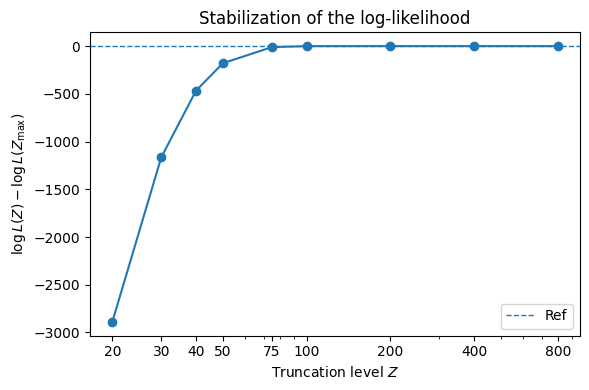

In [21]:
plt.figure(figsize=(6,4))
plt.plot(results["Z"], results["Diff_logL_vs_Zmax"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1, label=r"Ref")

plt.xscale("log")
plt.xticks(results["Z"], results["Z"])

plt.xlabel("Truncation level $Z$")
plt.ylabel(r"$\log L(Z) - \log L(Z_{\max})$")
plt.title("Stabilization of the log-likelihood")
plt.legend()
plt.tight_layout()
plt.show()


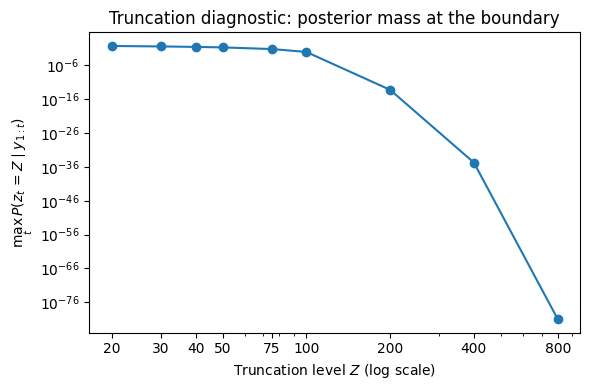

In [22]:
plt.figure(figsize=(6,4))
plt.plot(results["Z"], results["max_P_z_eq_Z"], marker="o")

plt.xscale("log")
plt.yscale("log")
plt.xticks(results["Z"], results["Z"])

plt.xlabel("Truncation level $Z$ (log scale)")
plt.ylabel(r"$\max_t\, P(z_t = Z \mid y_{1:t})$")
plt.title("Truncation diagnostic: posterior mass at the boundary")
plt.tight_layout()
plt.show()


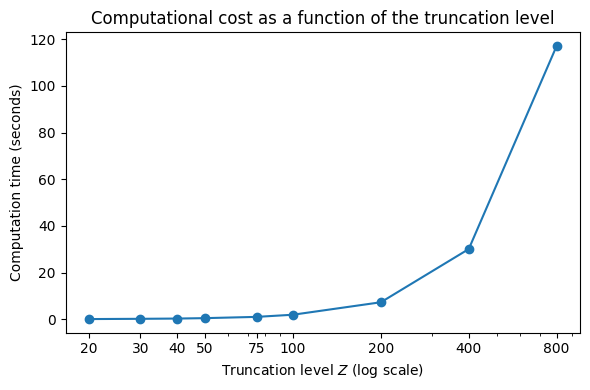

In [23]:
plt.figure(figsize=(6,4))
plt.plot(results["Z"], results["time_sec"], marker="o")

plt.xscale("log")
plt.xticks(results["Z"], results["Z"])

plt.xlabel("Truncation level $Z$ (log scale)")
plt.ylabel("Computation time (seconds)")
plt.title("Computational cost as a function of the truncation level")
plt.tight_layout()
plt.show()


## Comparaison avec un particle filter 

Exact filter warm-up...

Running PF V1 scatter...


PF V1: 100%|██████████| 30/30 [12:40<00:00, 25.34s/it]



Running PF V2 scatter...


PF V2: 100%|██████████| 30/30 [01:12<00:00,  2.43s/it]


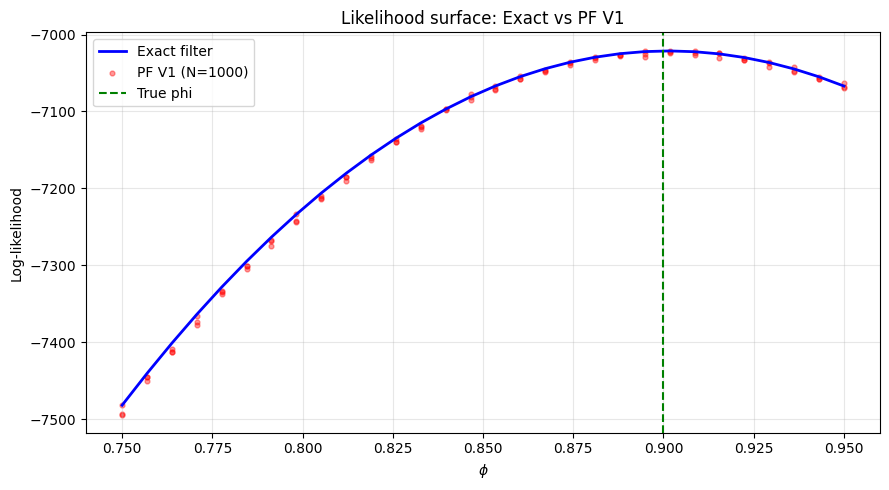

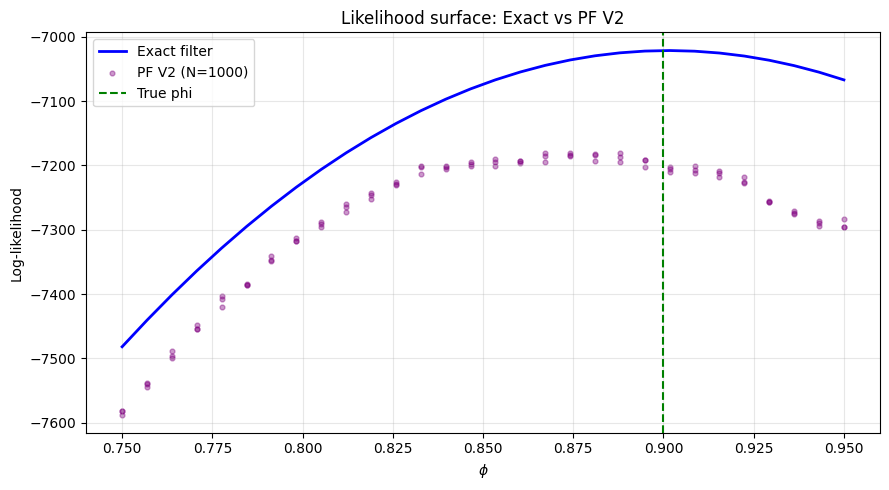

In [ ]:
# Settings (TEST RAPIDE)

TRUE_PARAMS = {"phi": 0.9, "nu": 2.5, "c": 0.2}

Z_REF = 200             # 
N_PARTICLES = 1000     # 
R = 3                  # 
SEED0 = 123

phi_grid = np.linspace(0.75, 0.95, 30)  

# Exact filter (warm-up + ref)

print("Exact filter warm-up...")
exact_filter = ef.ExactFilter(y, Z_trunc=Z_REF)
_ = exact_filter.log_likelihood(**TRUE_PARAMS)  # compile numba

# Containers communs

ll_exact = np.empty(phi_grid.size)

# 1) GRAPH 1 : PF V1

phi_scatter_v1 = []
ll_pf_scatter_v1 = []

print("\nRunning PF V1 scatter...")
for i in trange(phi_grid.size, desc="PF V1"):
    phi = phi_grid[i]

    # exact likelihood (1 fois)
    ll_exact[i] = exact_filter.log_likelihood(
        phi=phi,
        nu=TRUE_PARAMS["nu"],
        c=TRUE_PARAMS["c"]
    )

    # PF V1 (R fois)
    for r in range(R):
        ll_hat = pf1.loglik_pf_once(
            y,
            phi=phi,
            nu=TRUE_PARAMS["nu"],
            c=TRUE_PARAMS["c"],
            N=N_PARTICLES,
            seed=SEED0 + 100*i + r
        )
        phi_scatter_v1.append(phi)
        ll_pf_scatter_v1.append(ll_hat)


# PLOT 1 : Exact + PF V1

plt.figure(figsize=(9, 5))

plt.plot(phi_grid, ll_exact, lw=2, color="blue", label="Exact filter")
plt.scatter(
    phi_scatter_v1,
    ll_pf_scatter_v1,
    s=12,
    alpha=0.4,
    color="red",
    label=f"PF V1 (N={N_PARTICLES})"
)

plt.axvline(TRUE_PARAMS["phi"], color="green", ls="--", label="True phi")

plt.xlabel(r"$\phi$")
plt.ylabel("Log-likelihood")
plt.title("Likelihood surface: Exact vs PF V1")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Exact filter warm-up...

Running PF V1 scatter...


phi grid: 100%|██████████| 80/80 [54:05<00:00, 40.57s/it]


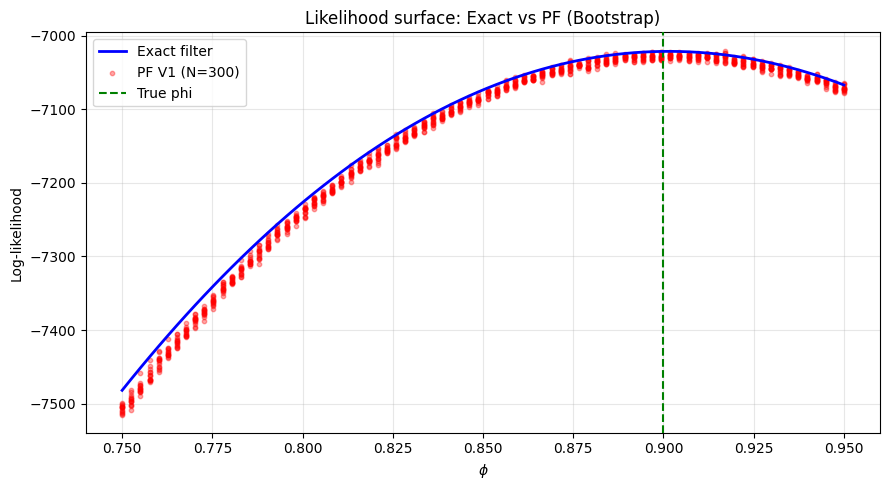

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

import utils.exact_filter as ef
import utils.particle_v1 as pf1

# ======================================================
# Settings (DEMO NUAGE - comme dans le papier)
# ======================================================
TRUE_PARAMS = {"phi": 0.9, "nu": 2.5, "c": 0.2}

Z_REF = 200

N_PARTICLES = 300      # ↓ volontairement petit → plus de bruit
R = 15                 # ↑ plus de répétitions → nuage épais
SEED0 = 123

phi_grid = np.linspace(0.75, 0.95, 80)  # ↑ grille plus dense

# ======================================================
# Exact filter (warm-up + reference)
# ======================================================
print("Exact filter warm-up...")
exact_filter = ef.ExactFilter(y, Z_trunc=Z_REF)
_ = exact_filter.log_likelihood(**TRUE_PARAMS)  # compile numba

# ======================================================
# Containers
# ======================================================
ll_exact = np.empty(phi_grid.size)
phi_scatter = []
ll_pf_scatter = []

# ======================================================
# Main loop : Exact + PF V1
# ======================================================
print("\nRunning PF scatter...")

for i in trange(phi_grid.size, desc="phi grid"):
    phi = phi_grid[i]

    # Exact likelihood (1 fois)
    ll_exact[i] = exact_filter.log_likelihood(
        phi=phi,
        nu=TRUE_PARAMS["nu"],
        c=TRUE_PARAMS["c"]
    )

    # PF V1 (R fois)
    for r in range(R):
        ll_hat = pf1.loglik_pf_once(
            y,
            phi=phi,
            nu=TRUE_PARAMS["nu"],
            c=TRUE_PARAMS["c"],
            N=N_PARTICLES,
            seed=SEED0 + 1000 * i + r
        )
        phi_scatter.append(phi)
        ll_pf_scatter.append(ll_hat)

# ======================================================
# Plot : Exact + PF V1
# ======================================================
plt.figure(figsize=(9, 5))

plt.plot(
    phi_grid,
    ll_exact,
    lw=2,
    color="blue",
    label="Exact filter",
    zorder=5
)

plt.scatter(
    phi_scatter,
    ll_pf_scatter,
    s=10,
    alpha=0.35,
    color="red",
    label=f"PF V1 (N={N_PARTICLES})",
    zorder=2
)

plt.axvline(
    TRUE_PARAMS["phi"],
    color="green",
    ls="--",
    label="True phi",
    zorder=4
)

plt.xlabel(r"$\phi$")
plt.ylabel("Log-likelihood")
plt.title("Likelihood surface: Exact vs PF (Bootstrap)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Effet N différents

In [ ]:
# Settings

TRUE_PARAMS = {"phi": 0.9, "nu": 2.5, "c": 0.2}

Z_REF = 200
phi_grid = np.linspace(0.75, 0.95, 150)

N_list = [100, 200, 300, 500, 1000, 2000]
R = 12
SEED0 = 123

OUTDIR = "figures_pf_N"
os.makedirs(OUTDIR, exist_ok=True)


# Exact filter (warm-up + référence)
print("Exact filter warm-up...")
exact_filter = ef.ExactFilter(y, Z_trunc=Z_REF)
_ = exact_filter.log_likelihood(**TRUE_PARAMS)  # compile numba

# Courbe exacte (calculée UNE fois)
ll_exact = np.empty(phi_grid.size)
for i, phi in enumerate(phi_grid):
    ll_exact[i] = exact_filter.log_likelihood(
        phi=phi,
        nu=TRUE_PARAMS["nu"],
        c=TRUE_PARAMS["c"]
    )


# Boucle sur N
fig, axes = plt.subplots(
    1, len(N_list),
    figsize=(5 * len(N_list), 4),
    sharey=True
)

if len(N_list) == 1:
    axes = [axes]

for ax, N_PARTICLES in zip(axes, N_list):

    print(f"\n=== Running PF for N = {N_PARTICLES} ===")

    phi_scatter = []
    ll_pf_scatter = []

    for i in trange(phi_grid.size, desc=f"phi grid (N={N_PARTICLES})"):
        phi = phi_grid[i]

        for r in range(R):
            ll_hat = pf1.loglik_pf_once(
                y,
                phi=phi,
                nu=TRUE_PARAMS["nu"],
                c=TRUE_PARAMS["c"],
                N=N_PARTICLES,
                seed=SEED0 + 1000 * i + r
            )
            phi_scatter.append(phi)
            ll_pf_scatter.append(ll_hat)



    # Plot sur le subplot
    ax.plot(
        phi_grid,
        ll_exact,
        lw=2,
        color="blue",
        label="Exact"
    )

    ax.scatter(
        phi_scatter,
        ll_pf_scatter,
        s=10,
        alpha=0.35,
        color="red",
        label=f"PF (N={N_PARTICLES})"
    )

    ax.axvline(
        TRUE_PARAMS["phi"],
        color="green",
        ls="--",
        lw=1
    )

    ax.set_title(f"N = {N_PARTICLES}")
    ax.set_xlabel(r"$\phi$")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("Log-likelihood")

# Légende commune
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)

fig.suptitle(
    "Exact vs Particle Filter likelihood surface\n"
    f"(T={len(y)}, R={R})",
    y=1.05
)

fig.tight_layout()
fig.subplots_adjust(top=0.8)


# Sauvegarde de la figure côte à côte
fname_all = os.path.join(OUTDIR, "likelihood_surface_all_N.png")
plt.savefig(fname_all, dpi=300)
plt.show()



# Sauvegarde d'UNE figure par N (séparément)
for N_PARTICLES in N_list:

    plt.figure(figsize=(7, 4))

    phi_scatter = []
    ll_pf_scatter = []

    for i in range(phi_grid.size):
        phi = phi_grid[i]
        for r in range(R):
            ll_hat = pf1.loglik_pf_once(
                y,
                phi=phi,
                nu=TRUE_PARAMS["nu"],
                c=TRUE_PARAMS["c"],
                N=N_PARTICLES,
                seed=SEED0 + 1000 * i + r
            )
            phi_scatter.append(phi)
            ll_pf_scatter.append(ll_hat)

    plt.plot(phi_grid, ll_exact, lw=2, color="blue", label="Exact")
    plt.scatter(phi_scatter, ll_pf_scatter, s=10, alpha=0.35,
                color="red", label=f"PF (N={N_PARTICLES})")

    plt.axvline(TRUE_PARAMS["phi"], color="green", ls="--", label="True phi")

    plt.xlabel(r"$\phi$")
    plt.ylabel("Log-likelihood")
    plt.title(f"Exact vs PF likelihood (N={N_PARTICLES}, R={R})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    fname = os.path.join(OUTDIR, f"likelihood_surface_N{N_PARTICLES}.png")
    plt.savefig(fname, dpi=300)
    plt.close()

print(f"\nFigures saved in folder: {OUTDIR}")


## Données réelles 